# Importing the Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error,r2_score

# Loading the dataset

In [ ]:
df = pd.read_csv('/content/household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')

# Data Exploration

In [ ]:
df.shape

(1998110, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1998110 entries, 2006-12-16 17:24:00 to 2010-10-04 07:13:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 122.0 MB


In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,1.972132e+06,1.972131e+06,1.972131e+06,1.972131e+06,1.972131e+06,1.972131e+06,1.972131e+06
mean,1.088257e+00,1.236366e-01,2.408130e+02,4.614681e+00,1.123403e+00,1.299474e+00,6.442880e+00
std,1.059747e+00,1.125767e-01,3.216632e+00,4.453805e+00,6.162725e+00,5.829050e+00,8.429556e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.060000e-01,4.800000e-02,2.389800e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.940000e-01,1.000000e-01,2.409900e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.524000e+00,1.940000e-01,2.428500e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Data Preprocessing

In [ ]:
df.isnull().sum()

Global_active_power      25978
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
df = df.fillna(df.mean())

# Data Visualization

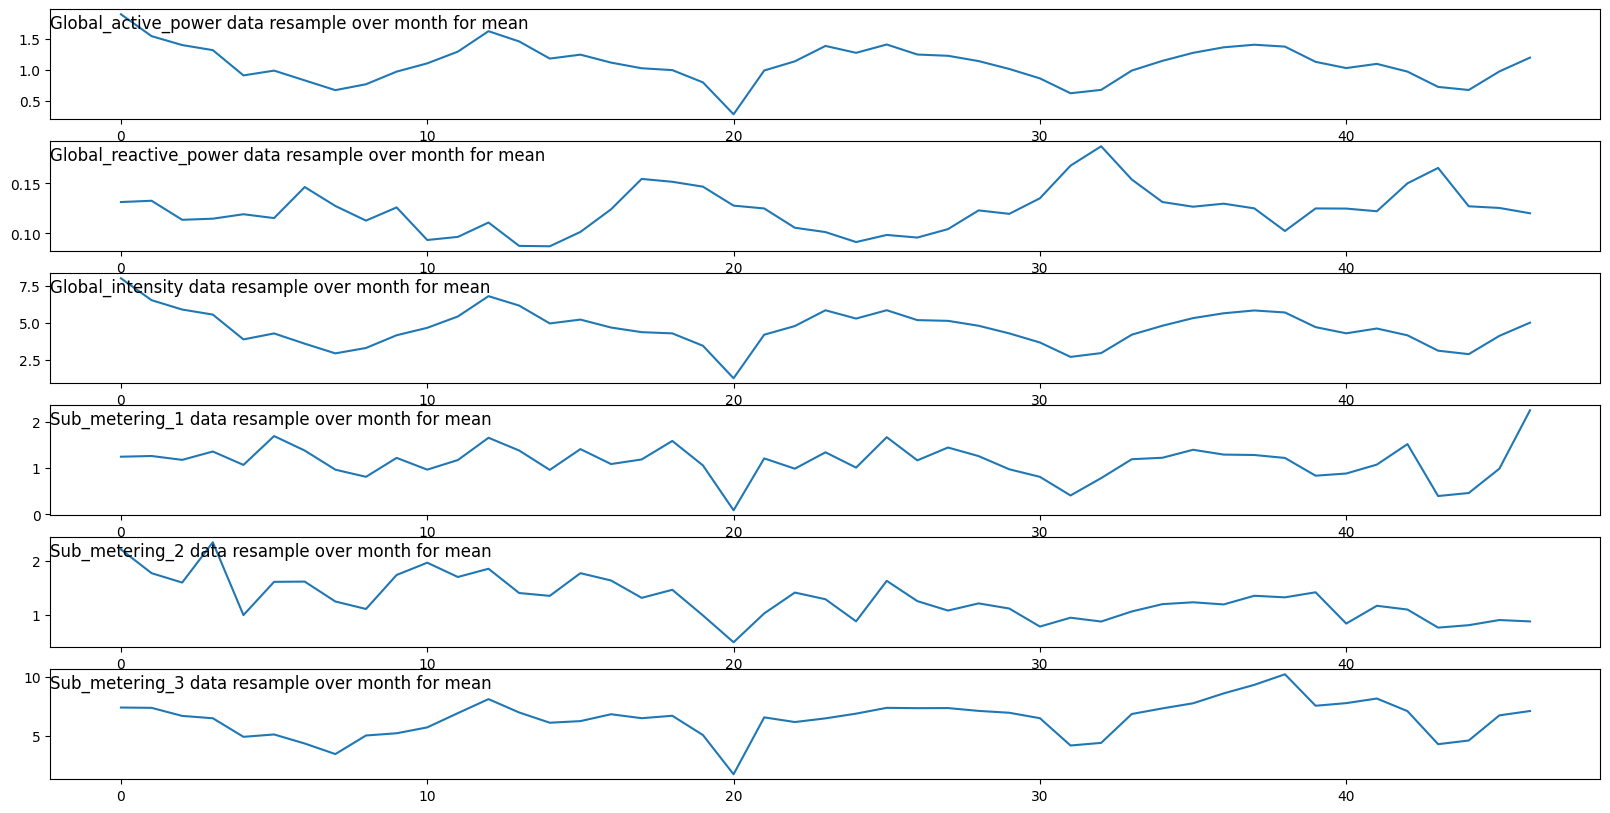

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

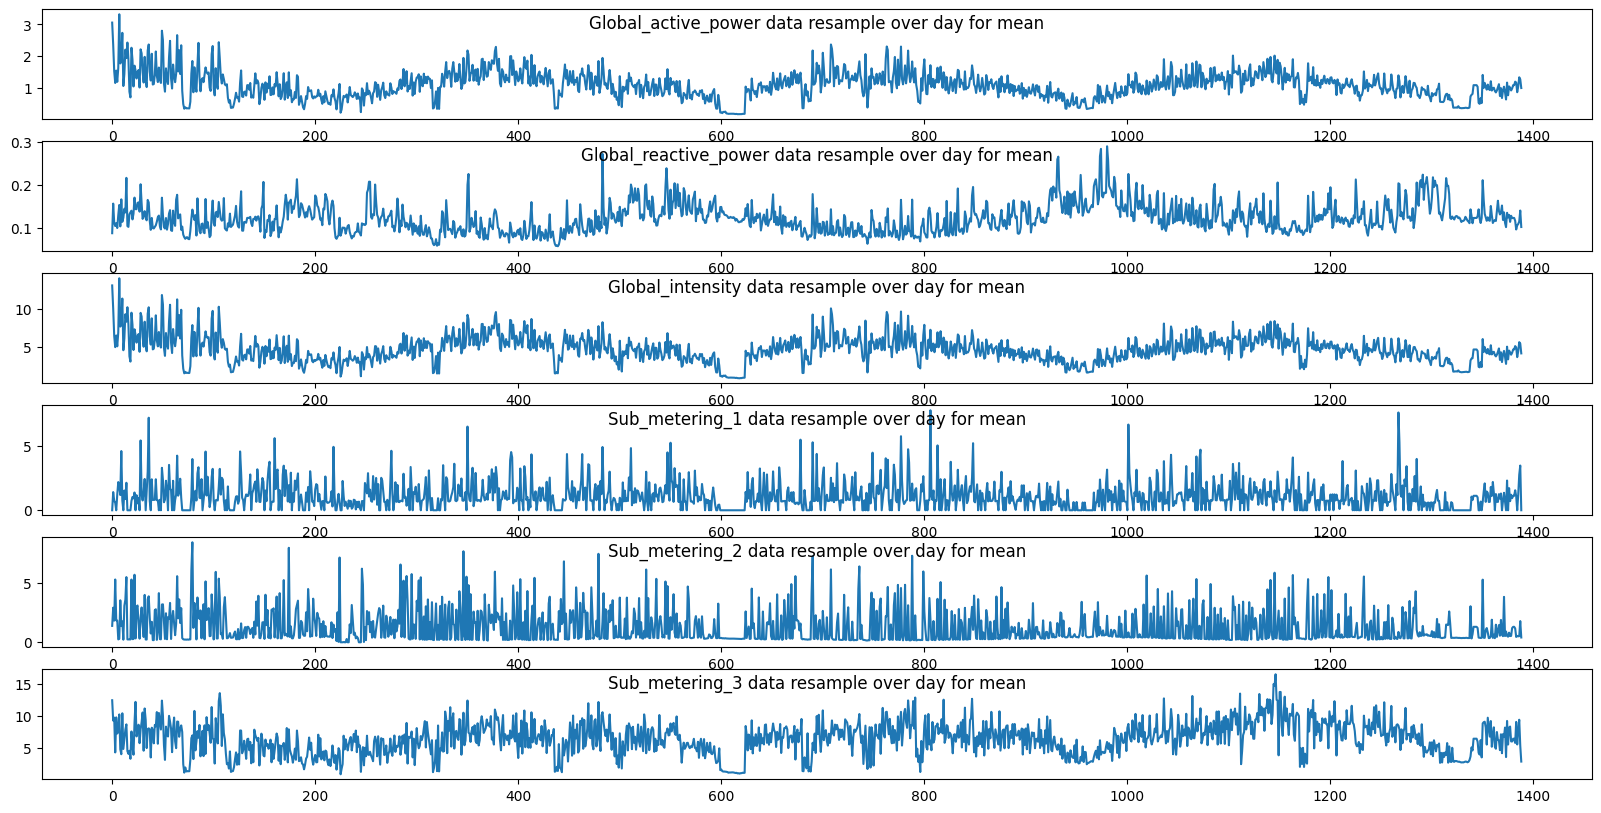

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

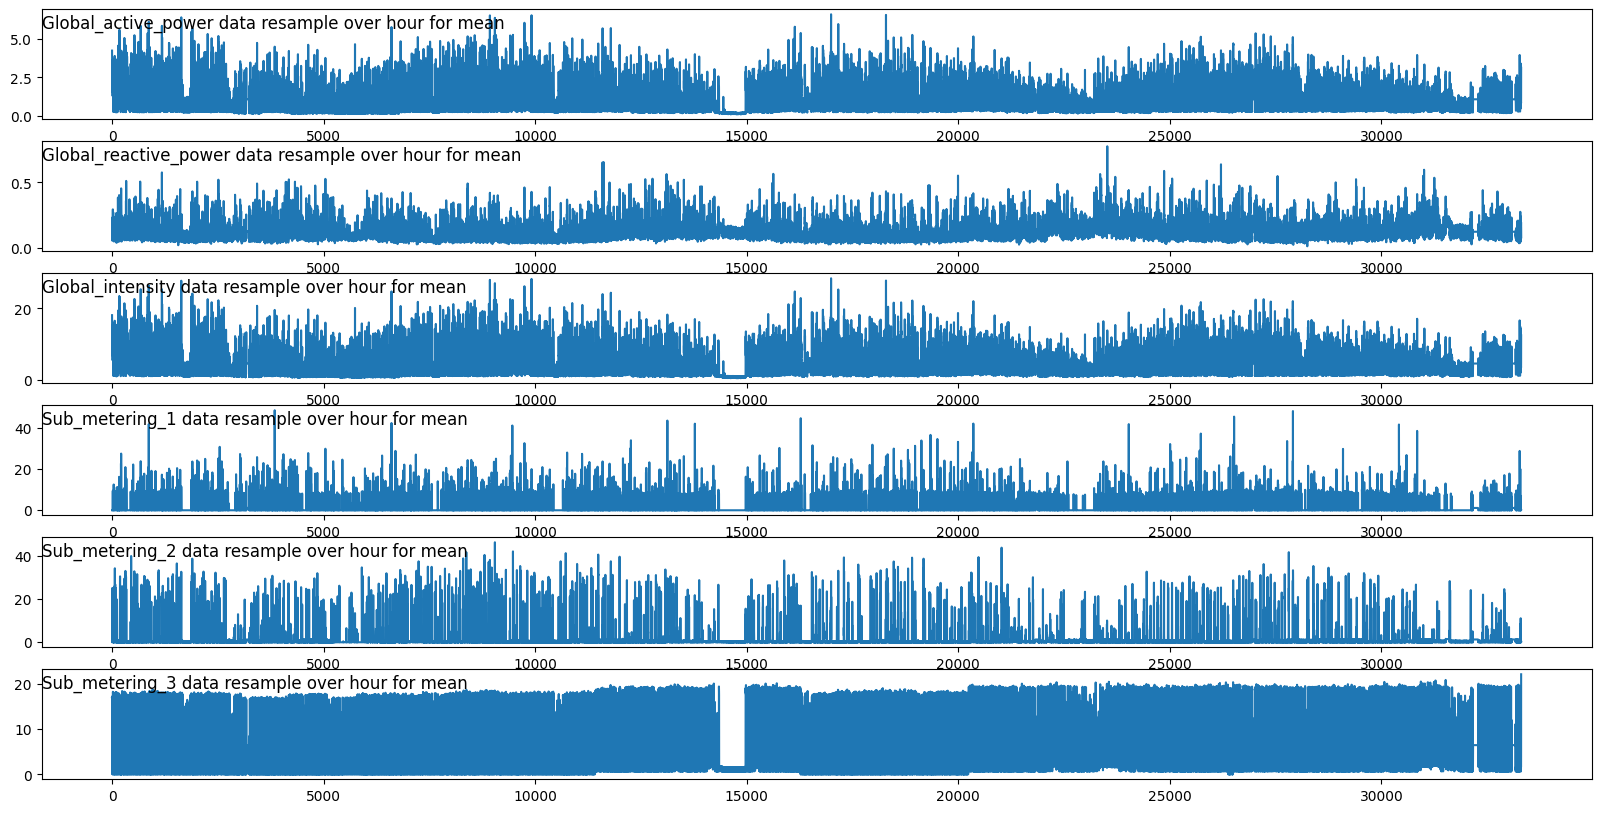

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

In [ ]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

Resampling of data

In [ ]:
df_resample = df.resample('h').mean()
df_resample.shape

(33303, 7)

In [ ]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace = True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.088127,0.335501,0.541487,0.144652,0.0,0.763092,0.636816
1,0.509006,0.094957,0.283802,0.502152,0.030869,0.0,0.754797,0.545045
2,0.488550,0.081648,0.315987,0.481110,0.000000,0.0,0.759322,0.509006
3,0.455597,0.083705,0.434417,0.449904,0.008973,0.0,0.778927,0.488550
4,0.322555,0.056781,0.495847,0.323529,0.002872,0.0,0.200576,0.455597


Data Spliting for training and testing

In [ ]:
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

# Using LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  run_eagerly=True)



In [ ]:
print(test_y)

[0.18031963 0.18706239 0.17914405 ... 0.1140469  0.11097589 0.16385632]


Network Fitting

In [ ]:
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/50
58/58 - 8s - loss: 0.0289 - val_loss: 0.0110 - 8s/epoch - 135ms/step
Epoch 2/50
58/58 - 12s - loss: 0.0158 - val_loss: 0.0102 - 12s/epoch - 212ms/step
Epoch 3/50
58/58 - 8s - loss: 0.0146 - val_loss: 0.0100 - 8s/epoch - 143ms/step
Epoch 4/50
58/58 - 12s - loss: 0.0138 - val_loss: 0.0099 - 12s/epoch - 210ms/step
Epoch 5/50
58/58 - 12s - loss: 0.0133 - val_loss: 0.0097 - 12s/epoch - 210ms/step
Epoch 6/50
58/58 - 8s - loss: 0.0128 - val_loss: 0.0095 - 8s/epoch - 140ms/step
Epoch 7/50
58/58 - 12s - loss: 0.0124 - val_loss: 0.0095 - 12s/epoch - 213ms/step
Epoch 8/50
58/58 - 8s - loss: 0.0122 - val_loss: 0.0094 - 8s/epoch - 134ms/step
Epoch 9/50
58/58 - 8s - loss: 0.0121 - val_loss: 0.0093 - 8s/epoch - 146ms/step
Epoch 10/50
58/58 - 8s - loss: 0.0120 - val_loss: 0.0093 - 8s/epoch - 143ms/step
Epoch 11/50
58/58 - 12s - loss: 0.0119 - val_loss: 0.0093 - 12s/epoch - 213ms/step
Epoch 12/50
58/58 - 8s - loss: 0.0118 - val_loss: 0.0092 - 8s/epoch - 130ms/step
Epoch 13/50
58/58 - 12s - l

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'val_loss'])


Loss History Plot

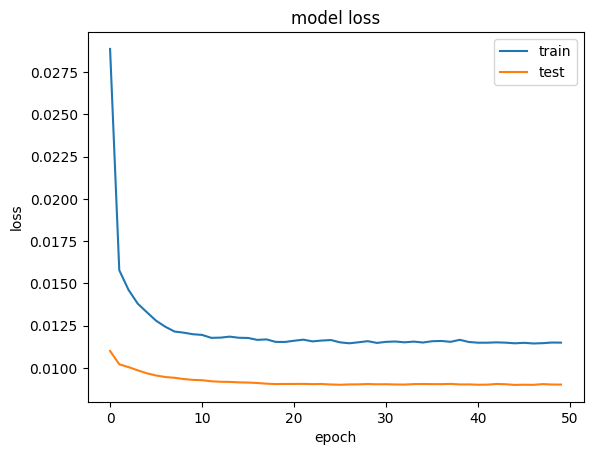

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
size = df_resample.shape[1]

Prediction Test

In [ ]:
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

916/916 [==============================] - 10s 11ms/step


Inverting scaling for Prediction

In [ ]:
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Inverting scaling for actual

In [ ]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculating RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.611


# Calculatung MSE

In [ ]:
mse = mean_squared_error(inv_y, inv_yhat)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.3732367360245424


Visual Representation of Actual verses Predicted

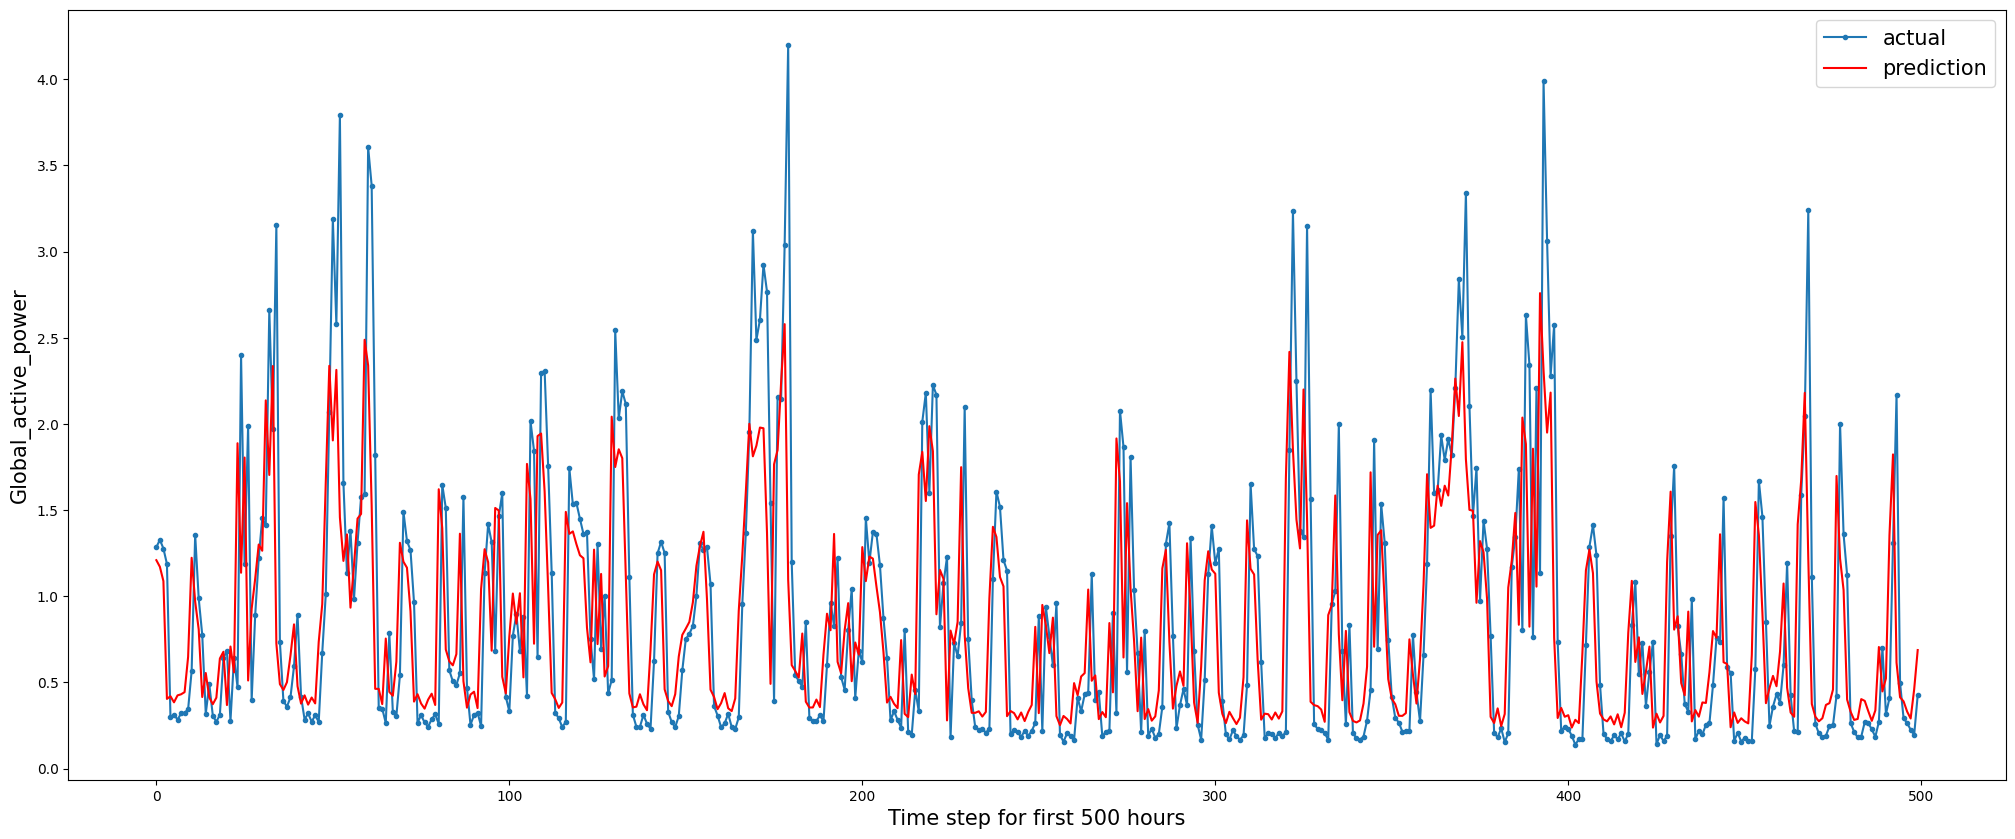

In [ ]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()